In [1]:
import xgboost as xgb
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pprint import pprint
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from scipy.stats import randint as sp_randint

from sklearn.metrics import mean_squared_error, r2_score
import mlflow
import hyperopt

from xgboost import XGBRegressor

In [30]:
def nse_score(simulated, observed):
    """
    Calculate Nash-Sutcliffe Efficiency (NSE) coefficient
    NSE = 1 - [Σ(Qo - Qs)² / Σ(Qo - Qo_mean)²]
    where:
    Qo = observed discharge
    Qs = simulated discharge
    """
    # numerator = np.sum((observed - simulated) ** 2)
    # denominator = np.sum((observed - np.mean(observed)) ** 2)
    # return 1 - (numerator / denominator)
    sum_squared_diff = np.sum((simulated - observed) ** 2)  # Sum of squared differences
    variance_B = np.var(observed, ddof=0)  # Variance of observed values
    count_B = len(observed)  # Count of observed values

    # Calculate NSE
    nse = 1 - (sum_squared_diff / (variance_B * count_B))
    return nse


def pbias_score(simulated, observed):
    """
    Calculate Percent Bias (PBIAS)
    PBIAS = [Σ(Qo - Qs) * 100] / Σ(Qo)
    where:
    Qo = observed discharge
    Qs = simulated discharge
    """
    numerator = (np.sum(observed) - np.sum(simulated)) * 100
    denominator = np.sum(observed)
    return numerator / denominator


In [31]:
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
import numpy as np


def hyperopt_tuning(X_train, y_train):
    def objective(params):
        model = XGBRegressor(
            objective="reg:squarederror",
            n_estimators=int(params["n_estimators"]),
            max_depth=int(params["max_depth"]),
            learning_rate=params["learning_rate"],
            subsample=params["subsample"],
            colsample_bytree=params["colsample_bytree"],
            reg_alpha=params["reg_alpha"],
            reg_lambda=params["reg_lambda"],
            random_state=42,
        )
        model.fit(X_train, y_train)

        # Predictions and evaluation on training set (to speed up tuning)
        y_pred = model.predict(X_train)
        mse = mean_squared_error(y_train, y_pred)

        return {"loss": mse, "status": STATUS_OK}

    # Define the parameter search space
    space = {
        "max_depth": hp.quniform("max_depth", 3, 18, 1),
        "gamma": hp.uniform("gamma", 1, 9),
        "reg_alpha": hp.quniform("reg_alpha", 40, 180, 1),
        "reg_lambda": hp.uniform("reg_lambda", 0, 1),
        "learning_rate": hp.loguniform("learning_rate", np.log(0.01), np.log(0.3)),
        "subsample": hp.uniform("subsample", 0.6, 1.0),
        "colsample_bytree": hp.uniform("colsample_bytree", 0.5, 1),
        "min_child_weight": hp.quniform("min_child_weight", 0, 10, 1),
        "n_estimators": hp.quniform(
            "n_estimators",
            100,
            300,
            10,
        ),
    }

    # Run HyperOpt optimization
    trials = Trials()
    best = fmin(
        fn=objective,
        space=space,
        algo=tpe.suggest,
        max_evals=50,
        trials=trials,
        rstate=np.random.default_rng(42),
    )

    # Return the best parameters found
    return {
        "n_estimators": int(best["n_estimators"]),
        "max_depth": int(best["max_depth"]),
        "learning_rate": best["learning_rate"],
        "subsample": best["subsample"],
        "colsample_bytree": best["colsample_bytree"],
        "reg_alpha": best["reg_alpha"],
        "reg_lambda": best["reg_lambda"],
    }


In [86]:
climate_data = pd.read_csv("data/Monthly_Climate_Data-1993-2020.csv")

In [87]:
climate_data

,Date,Precipitation,Evapotranspiration,MaxT,MinT,Unnamed: 5,Date.1,Precipitation.1,Evapotranspiration.1,MaxT.1,MinT.1
0,1/1/1993,0.330769,0.517,2.445385,-10.748462,NaN,Jan-93,65.490769,11.2995,0.169553,-9.159032
1,1/2/1993,0.101538,0.402,-3.736154,-10.940769,NaN,Feb-93,58.030769,10.3760,-2.432967,-16.710495
2,1/3/1993,1.456923,0.782,1.354615,-10.342308,NaN,Mar-93,123.076923,18.0360,3.588660,-8.021911
3,1/4/1993,5.001538,0.378,8.511538,-1.980769,NaN,Apr-93,163.026154,52.2200,12.510615,0.741641
4,1/5/1993,12.960000,0.412,10.614615,-5.325385,NaN,May-93,28.816923,86.4000,19.484194,4.743598
...,...,...,...,...,...,...,...,...,...,...,...
10222,12/27/2020,0.000000,0.430,0.545385,-6.360769,NaN,NaN,NaN,NaN,NaN,NaN
10223,12/28/2020,1.398462,0.517,4.414615,-4.636154,NaN,NaN,NaN,NaN,NaN,NaN
10224,12/29/2020,1.252308,0.214,-2.451538,-11.190000,NaN,NaN,NaN,NaN,NaN,NaN
10225,12/30/2020,3.383077,0.540,2.180769,-6.837692,NaN,NaN,NaN,NaN,NaN,NaN


In [105]:
observed = pd.read_excel(
    "/Users/azamkhan/columbia/climate/swan_ml/data/Observed_WaterQuality_Upstream_of_Delhi.xlsx",
    sheet_name=["Sediments", "Nitrate", "Phosphate", "TotalP"],

    usecols=[0, 1]
)
for key in observed:
    observed[key] = observed[key].set_index('Date')
    observed[key].index = observed[key].index.strftime("%b-%y")
    observed[key] = observed[key].reset_index()

# observed = pd.concat(observed, ignore_index=True)

targets = []
for key in observed:
    targets.append(observed[key].columns[1])



simulated = pd.read_excel(
    "/Users/azamkhan/columbia/climate/swan_ml/data/Observed_WaterQuality_Upstream_of_Delhi.xlsx",
    sheet_name=0,
    usecols=[0,1,2,3,4,5]
)
simulated = simulated.set_index('Date')
simulated.index = simulated.index.strftime("%b-%y")
simulated = simulated.reset_index()

remaining_input_data = pd.read_csv("data/cal_swat_climate_dataset.csv", usecols=[1,2,3,4,5])
# aggregate remaining_input_data by month
remaining_input_data['Date'] = pd.to_datetime(remaining_input_data['Date'])
remaining_input_data = remaining_input_data.set_index('Date')
remaining_input_data = remaining_input_data.resample('M').mean()
remaining_input_data.index = remaining_input_data.index.strftime("%b-%y")
remaining_input_data = remaining_input_data.reset_index()

# merge observed and simulated data with climate data
for key in observed:
    observed[key] = observed[key].merge(
        simulated, on="Date", how="left"
    )#.drop(columns=["Date_simulated"]).rename(columns={"Date_observed": "Date"})
    observed[key] = observed[key].merge(remaining_input_data, on="Date", how="inner")


In [107]:
water_quality_datasets = {}
water_quality_datasets["Sediments DlyLd(kg*1000)"] = observed.pop(
    "Sediments"
)
water_quality_datasets["Nitrate DlyLd(kg)"] = observed.pop("Nitrate")
water_quality_datasets["Phosphate DlyLd(kg)"] = observed.pop("Phosphate")
water_quality_datasets["TotalP"] = observed.pop("TotalP")


In [108]:
# input features to target variable mapping

features = {
    "Sediments DlyLd(kg*1000)": [
        "Streamflow",
        "Calibrated_SWAT_Sediments DlyLd(kg*1000)",
    ],
    "Nitrate DlyLd(kg)": [
        "Streamflow",
        "Calibrated_SWAT_Sediments DlyLd(kg*1000)",
        "Calibrated_SWAT_Nitrate DlyLd(kg)",
    ],
    "Phosphate DlyLd(kg)": [
        "Streamflow",
        "Calibrated_SWAT_Sediments DlyLd(kg*1000)",
        "Calibrated_SWAT_Nitrate DlyLd(kg)",
        "Calibrated_SWAT_Phosphate DlyLd(kg)",
    ],
    "TotalP": [
        "Streamflow",
        "Calibrated_SWAT_Sediments DlyLd(kg*1000)",
        "Calibrated_SWAT_Nitrate DlyLd(kg)",
        "Calibrated_SWAT_Phosphate DlyLd(kg)",
        "Calibrated_SWAT_TotalP",
    ],
}


In [42]:
# Define the XGBoost Regressor model
xgb_model = XGBRegressor(
    objective="reg:squarederror",
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    random_state=42,
)


# Run experiments for each target variable
results = {target: {} for target in targets}
model_val_preds = {}
y_vals = {}
model_inputs = {}
model_test_preds = {}
y_tests = {}

for target in targets:
    modelling_data = water_quality_datasets[target]
    X = modelling_data.drop(columns=["Date", target], axis=1)
    y = modelling_data[["Date", target]]

    
    X = X.drop(
        columns=[
            col
            for col in X.columns
            if col.startswith("Calibrated_SWAT") and col not in features[target]
        ]
    )
    print(X.columns)

    # Split the data into train (60%), validation (20%), and test (20%) sets
    X_train, X_temp, y_train, y_temp = train_test_split(
        X, y, test_size=0.3, random_state=42, shuffle=False
    )
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=0.5, random_state=42, shuffle=False
    )
    y_vals[target] = y_val
    y_tests[target] = y_test

    # drop the date column from the y arrays
    # y_train = y_train[target]
    # y_val = y_val[target]
    # y_test = y_test[target]

    # X = select_features(X_train, y_train[target], target)

    # print size of each dataset
    print(f"Size of training dataset for target variable {target}: {X_train.shape[0]}")
    print(f"Size of validation dataset for target variable {target}: {X_val.shape[0]}")
    print(f"Size of test dataset for target variable {target}: {X_test.shape[0]}")

    # print selected features
    print(f"Selected features for target variable {target}:\n", X.columns)


    
    X_train = X_train[X.columns]
    X_val = X_val[X.columns]
    X_test = X_test[X.columns]

    # Standardize the data (train/val/test separately)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)
    X_test = scaler.transform(X_test)

    print(f"Hyperparameter tuning for target: {target}")
    best_params = hyperopt_tuning(X_train, y_train[target])
    print("Best parameters:", best_params)

    # Train the model with the best parameters
    model = XGBRegressor(objective="reg:squarederror", random_state=42, **best_params)
    model.fit(X_train, y_train[target])

    # rf_model.fit(X_train, y_train[target])

    # Evaluate the model on the test set
    y_pred_val = model.predict(X_val)
    model_val_preds[target] = y_pred_val

    # Calculate performance metrics

    # y_pred_exp = np.expm1(y_pred)  # Reverse log transformation on predictions
    # y_val_exp = np.expm1(y_val)    # Reverse log transformation on validation target

    # r2 = r2_score(y_val_exp, y_pred_exp)
    # nse = nse_score(y_val_exp, y_pred_exp)
    # pbias = pbias_score(y_val_exp, y_pred_exp)
    y_pred_test = model.predict(X_test)
    model_test_preds[target] = y_pred_test

    r2 = r2_score(y_test[target], y_pred_test)
    nse = nse_score(y_test[target], y_pred_test)
    pbias = pbias_score(y_test[target], y_pred_test)

    # Store feature importances for Random Forest
    feature_importances = model.feature_importances_
    results[target] = {
        "R2": r2,
        "NSE": nse,
        "PBIAS": pbias,
        "Feature Importances": feature_importances,
        "Model": model,
        "Model Inputs": X.columns,
    }


# Print the final results for all target variables
pprint(results)


Index(['Precipitation', 'Evapotranspiration', 'MaxT', 'MinT'], dtype='object')
Size of training dataset for target variable Sediments DlyLd(kg*1000): 73
Size of validation dataset for target variable Sediments DlyLd(kg*1000): 16
Size of test dataset for target variable Sediments DlyLd(kg*1000): 16
Selected features for target variable Sediments DlyLd(kg*1000):
 Index(['Precipitation', 'Evapotranspiration', 'MaxT', 'MinT'], dtype='object')
Hyperparameter tuning for target: Sediments DlyLd(kg*1000)
  6%|▌         | 3/50 [00:00<00:04,  9.82trial/s, best loss: 627.5137428318981]

This version of python seems to be incorrectly compiled
(internal generated filenames are not absolute).
This may make the debugger miss breakpoints.
Related bug: http://bugs.python.org/issue1666807


100%|██████████| 50/50 [00:04<00:00, 10.45trial/s, best loss: 53.38087385682883] 
Best parameters: {'n_estimators': 200, 'max_depth': 10, 'learning_rate': 0.19589581745907259, 'subsample': 0.7924952240930654, 'colsample_bytree': 0.8794035455619106, 'reg_alpha': 42.0, 'reg_lambda': 0.24549329601655276}
Index(['Calibrated_SWAT_Nitrate DlyLd(kg)', 'Precipitation',
       'Evapotranspiration', 'MaxT', 'MinT'],
      dtype='object')
Size of training dataset for target variable Nitrate DlyLd(kg): 107
Size of validation dataset for target variable Nitrate DlyLd(kg): 23
Size of test dataset for target variable Nitrate DlyLd(kg): 23
Selected features for target variable Nitrate DlyLd(kg):
 Index(['Calibrated_SWAT_Nitrate DlyLd(kg)', 'Precipitation',
       'Evapotranspiration', 'MaxT', 'MinT'],
      dtype='object')
Hyperparameter tuning for target: Nitrate DlyLd(kg)
100%|██████████| 50/50 [00:06<00:00,  7.28trial/s, best loss: 66.71259794528525] 
Best parameters: {'n_estimators': 220, 'max_dep

In [43]:
# create dataframe for exp3_results only showing the metrics
results_df = pd.DataFrame(results).T.drop(
    columns=["Feature Importances", "Model", "Model Inputs"]
)
results_df


,R2,NSE,PBIAS
Sediments DlyLd(kg*1000),0.022945,-0.166085,3.236692
Nitrate DlyLd(kg),0.797438,0.716271,-3.776939
Phosphate DlyLd(kg),0.64722,0.603623,-0.574263
TotalP,0.750868,0.426168,-27.877561


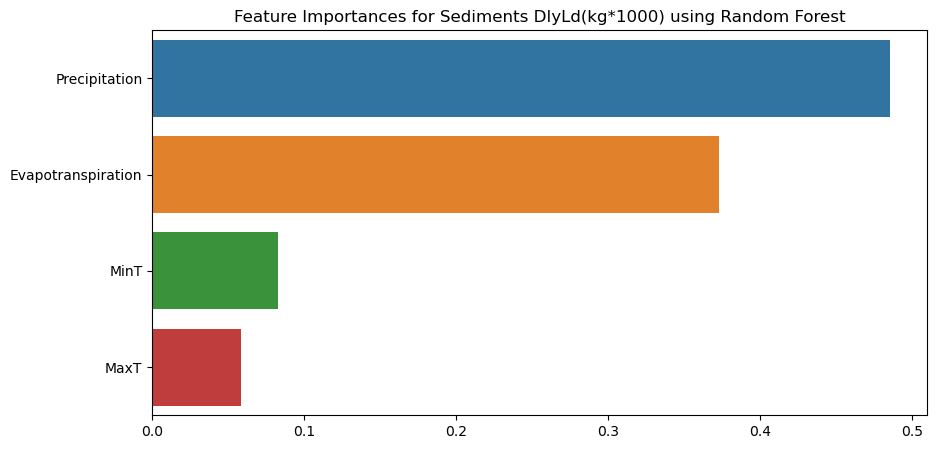

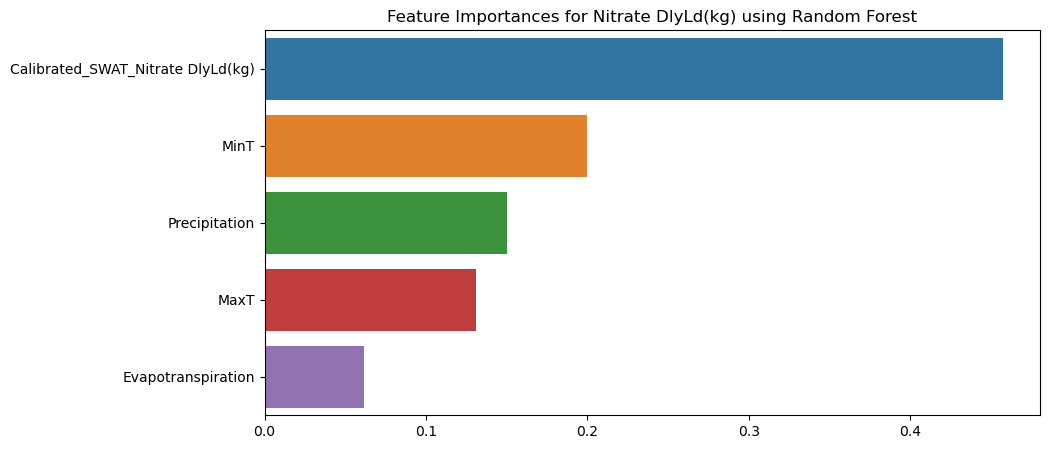

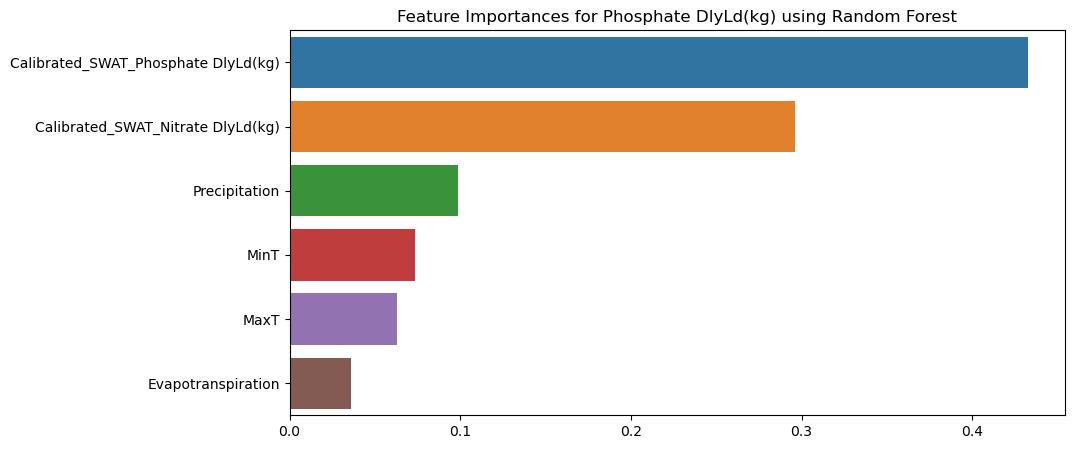

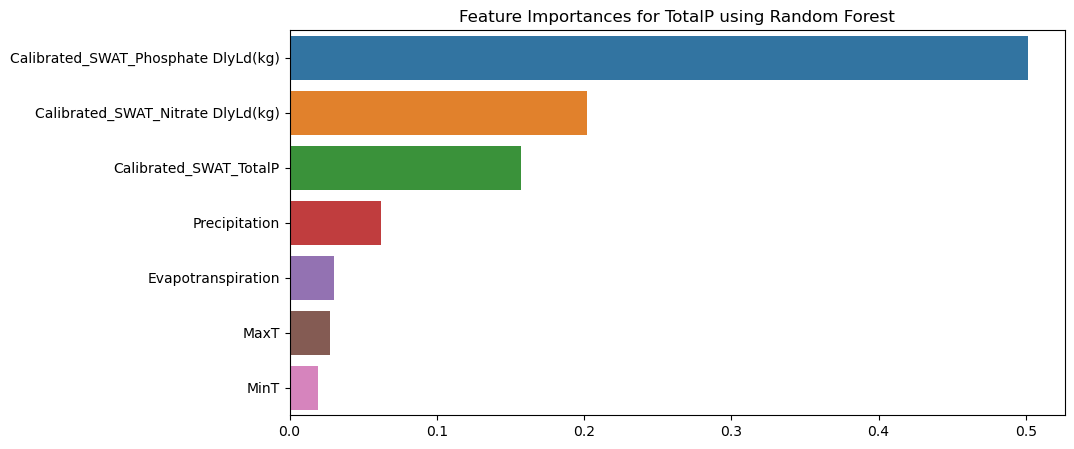

In [44]:
# plot feature importances and arrange them in descending order
for target in targets:
    feature_importances = results[target]["Feature Importances"]
    sorted_indices = np.argsort(feature_importances)[::-1]
    sorted_features = results[target]["Model Inputs"][sorted_indices]
    sorted_importances = feature_importances[sorted_indices]

    plt.figure(figsize=(10, 5))
    sns.barplot(x=sorted_importances, y=sorted_features)
    plt.title(f"Feature Importances for {target} using Random Forest")
    plt.show()


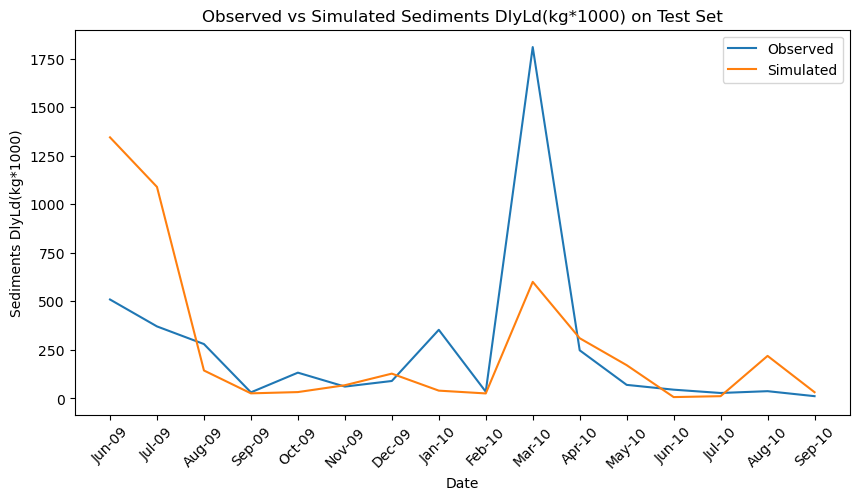

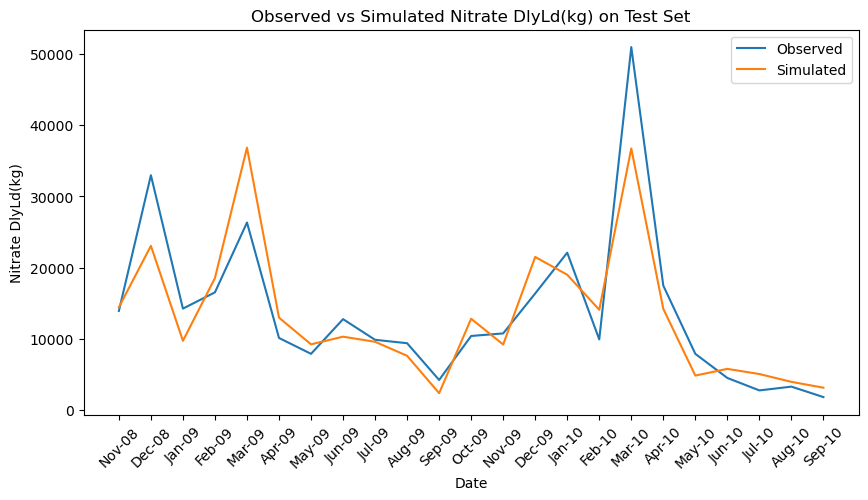

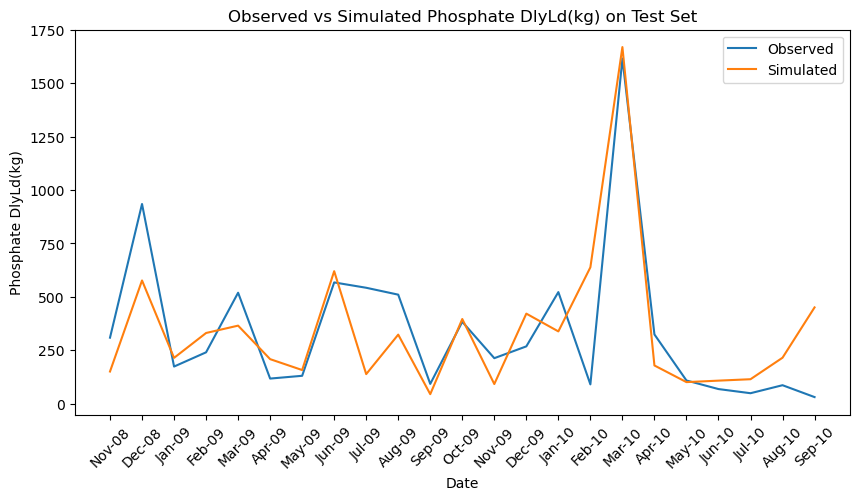

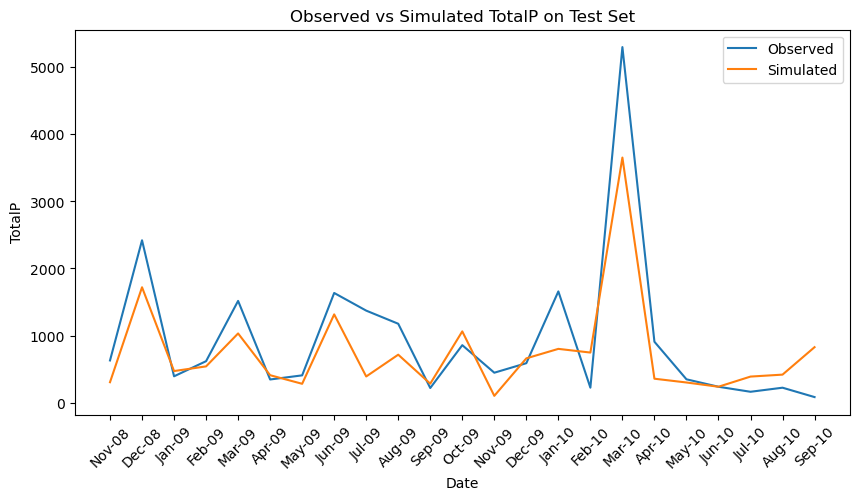

In [45]:
# plot line graph of observed vs simulated values

for target in targets:
    y_test = y_tests[target]
    y_test_pred = model_test_preds[target]


    plt.figure(figsize=(10, 5))
    plt.plot(y_test["Date"], y_test[target], label="Observed")
    plt.plot(y_test["Date"], y_test_pred, label="Simulated")
    plt.title(f"Observed vs Simulated {target} on Test Set")
    plt.xlabel("Date")
    plt.ylabel(target)
    plt.xticks(rotation=45)
    plt.legend()
    plt.show()

## Load pretrained model on other site

In [2]:
run_id_model_mapping = {
    "Sediments DlyLd(kg*1000)": "b3477c49eddb42959547e70c7fe37c90",
    "Nitrate DlyLd(kg)": "298cdd00c7df457b9f5eb57d30ec474e",
    "Phosphate DlyLd(kg)": "9114b153173c45719b51b9eda272a4d9",
    "TotalP": "02a7375a42094921bd6b3b879141a5ff",
}


In [3]:
import json
# mlflow.set_tracking_uri("http://localhost:5000")
def select_features(target):
    # Fit a preliminary model to get feature importances
    run_id = run_id_model_mapping[target]  # Extract the actual run ID


    artifact_path = f"{target.split(' ')[0]}_xgb_input_features.json"

    # Download the artifact locally
    local_path = mlflow.artifacts.download_artifacts(
        run_id=run_id, artifact_path=artifact_path
    )

    # Load the JSON file
    with open(local_path, "r") as f:
        loaded_dict = json.load(f)

    # Print the loaded dictionary
    # pprint(loaded_dict["input_features"])
    return loaded_dict["input_features"]


In [95]:
def load_scaler(target):
    
    run_id = run_id_model_mapping[target]
    logged_model = (
       f"runs:/{run_id}/{target}_scaler"
    )

    # Load model
    loaded_model = mlflow.sklearn.load_model(logged_model)
    return loaded_model

In [75]:
## feature engineering

def date_feature_transformations(dataset):
    dataset["Date"] = pd.to_datetime(dataset["Date"], format="%b-%y")


    dataset["year"] = dataset["Date"].dt.year
    dataset["month"] = dataset["Date"].dt.month

    # Create cyclic features for MOY (Month of the year)
    dataset["DOY_cos"] = np.cos(2 * np.pi * dataset["month"] / 12)

    # Calculate temperature range (diurnal temperature range)
    dataset["Temp_range"] = dataset["MaxT"] - dataset["MinT"]
    # Display the updated datasetframe with new features
    # dataset.head()
    return dataset

def create_lagged_features(dataset, lag_days):
    for lag in lag_days:
        dataset[f"Precipitation_lag{lag}"] = dataset["Precipitation"].shift(lag)
        dataset[f"Evapotranspiration_lag{lag}"] = dataset["Evapotranspiration"].shift(
            lag
        )
        dataset[f"MinT_lag{lag}"] = dataset["MinT"].shift(lag)
        dataset[f"MaxT_lag{lag}"] = dataset["MaxT"].shift(lag)

    # Fill the missing values created by shifting with the first available value
    dataset.fillna(method="bfill", inplace=True)
    return dataset


In [99]:
# create pipeline for inference

# pipeline steps:
# 1. Apply feature engineering
# 2. Select features
# 3. standardize the data
# 4. load the model
# 5. model prediction
# 6. calculate performance metrics
# 7. store results


from sklearn.preprocessing import StandardScaler

targets = list(run_id_model_mapping.keys())

results = {target: {} for target in targets}
y_preds = {}
model_inputs = {}
for target in targets:

    # feature engineering
    water_quality_datasets[target] = date_feature_transformations(
        water_quality_datasets[target]
    )
    water_quality_datasets[target] = create_lagged_features(
        water_quality_datasets[target], [1, 3, 7]
    )

    mlflow_model_uri = f"runs:/{run_id_model_mapping[target]}/xgb_model"
    loaded_model = mlflow.pyfunc.load_model(mlflow_model_uri)
    X = water_quality_datasets[target].drop(columns=["Date", target], axis=1)
    y = water_quality_datasets[target][['Date',target]]

    input_features = select_features(target)
    print(X.columns)
    X = X[input_features]
    scaler = load_scaler(target)
    X = scaler.transform(X)
    

    y_pred = loaded_model.predict(X)
    y_preds[target] = y_pred

    r2 = r2_score(y[target], y_pred)
    nse = nse_score(y[target], y_pred)
    pbias = pbias_score(y[target], y_pred)

    results[target] = {
        "R2": r2,
        "NSE": nse,
        "PBIAS": pbias,
        "Model Inputs": X
    }

Index(['Calibrated_SWAT_Streamflow',
       'Calibrated_SWAT_Sediments DlyLd(kg*1000)', 'Calibrated_SWAT_TotalP',
       'Calibrated_SWAT_Nitrate DlyLd(kg)',
       'Calibrated_SWAT_Phosphate DlyLd(kg)', 'Precipitation',
       'Evapotranspiration', 'MaxT', 'MinT', 'year', 'month', 'DOY_cos',
       'Temp_range', 'Precipitation_lag1', 'Evapotranspiration_lag1',
       'MinT_lag1', 'MaxT_lag1', 'Precipitation_lag3',
       'Evapotranspiration_lag3', 'MinT_lag3', 'MaxT_lag3',
       'Precipitation_lag7', 'Evapotranspiration_lag7', 'MinT_lag7',
       'MaxT_lag7'],
      dtype='object')
Index(['Calibrated_SWAT_Streamflow',
       'Calibrated_SWAT_Sediments DlyLd(kg*1000)', 'Calibrated_SWAT_TotalP',
       'Calibrated_SWAT_Nitrate DlyLd(kg)',
       'Calibrated_SWAT_Phosphate DlyLd(kg)', 'Precipitation',
       'Evapotranspiration', 'MaxT', 'MinT', 'year', 'month', 'DOY_cos',
       'Temp_range', 'Precipitation_lag1', 'Evapotranspiration_lag1',
       'MinT_lag1', 'MaxT_lag1', 'Precipitati

In [102]:
results_df = pd.DataFrame(results).T.drop(
    columns=["Model Inputs"]
)

In [104]:
results_df

,R2,NSE,PBIAS
Sediments DlyLd(kg*1000),-0.278536,-16001.784174,-1655.728335
Nitrate DlyLd(kg),-1.370552,-5357.841357,-1498.304537
Phosphate DlyLd(kg),-0.777541,-8177.072343,-1408.20367
TotalP,-0.582201,-1833.16507,-810.326622
